In [1]:
import subprocess
import geojson
import firedrake
import icepack
import numpy as np
import math
import rasterio
import icepack.plot
from firedrake import assemble, Constant, inner, grad, dx
import matplotlib.pyplot as plt
import pickle
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)
from rasterio.plot import show
import geojson
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import pandas as pd
from rasterio.crs import CRS
from rasterio.transform import from_origin
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
with open("/home/sermilik/brunt_model/output_extraction_locations.pkl", "rb") as f1:
    extraction_locations = pickle.load(f1)

f1.close()

#perpendicular angles
west_angle = extraction_locations["west_angle"]
east_angle = extraction_locations["east_angle"]
#extraction points
w_n_x_calv = extraction_locations["w_n_x_calv"]
w_n_y_calv = extraction_locations["w_n_y_calv"]
w_s_x_calv = extraction_locations["w_s_x_calv"]
w_s_y_calv = extraction_locations["w_s_y_calv"]
e_n_x_calv = extraction_locations["e_n_x_calv"]
e_n_y_calv = extraction_locations["e_n_y_calv"]
e_s_x_calv = extraction_locations["e_s_x_calv"]
e_s_y_calv = extraction_locations["e_s_y_calv"]


with open("/home/sermilik/brunt_model/output_for_plotting.pkl", "rb") as f2:
    for_plotting = pickle.load(f2)
    
f2.close()

xmin = for_plotting["xmin"]
xmax = for_plotting["xmax"]
ymin = for_plotting["ymin"]
ymax = for_plotting["ymax"]
xmin_ew = for_plotting["xmin_ew"]
xmax_ew = for_plotting["xmax_ew"]
ymin_ew = for_plotting["ymin_ew"]
ymax_ew = for_plotting["ymax_ew"]
xcen_w = for_plotting["xcen_w"]
ycen_w = for_plotting["ycen_w"]
xcen_e = for_plotting["xcen_e"]
ycen_e = for_plotting["ycen_e"]
delta = for_plotting["delta"]
easting_w_n = for_plotting["easting_w_n"]
northing_w_n = for_plotting["northing_w_n"]
easting_w_s = for_plotting["easting_w_s"]
northing_w_s = for_plotting["northing_w_s"]
easting_e_n = for_plotting["easting_e_n"]
northing_e_n = for_plotting["northing_e_n"]
easting_e_s = for_plotting["easting_e_s"]
northing_e_s = for_plotting["northing_e_s"]

extent = (xmin, xmax, ymin, ymax)


### Geometry

In [3]:
outline_2021 = '/home/sermilik/brunt_model/d02_calving/brunt_HC_2021_calving_coarse.geojson'
#Brunt_SWIT_HC_2020_cutoff_r.geojson'
#brunt_HC_2020.geojson'

with open(outline_2021,"r") as outline_file_2021:
    outline_2021 = geojson.load(outline_file_2021)
    
print(outline_2021["crs"]["properties"]["name"])

urn:ogc:def:crs:EPSG::3031


### Imagery

In [4]:
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
image_file = rasterio.open(image_filename, "r")

transform = image_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax, transform=transform
)

image = image_file.read(indexes=1, window=window, masked=True)

### meshing

In [5]:
geometry_2021 = icepack.meshing.collection_to_geo(outline_2021)

with open("brunt_2021.geo", "w") as geo_file_2021:
    geo_file_2021.write(geometry_2021.get_code())
    
!gmsh -2 -format msh2 -v 2 -o brunt_2021.msh brunt_2021.geo

mesh_2021 = firedrake.Mesh("brunt_2021.msh")

### Input data - thickness

In [6]:
thickness_filename = '/home/sermilik/brunt_model/thickness_brunt_fullcalc.tif'
thickness = rasterio.open(thickness_filename,"r")

Q_2021 = firedrake.FunctionSpace(mesh_2021, "CG", 2)
h0_2021 = icepack.interpolate(thickness, Q_2021)

In [7]:
#smooth the DEM

h_2021 = h0_2021.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J_2021 = 0.5 * (h_2021 - h0_2021)**2 * dx + 0.5 * α**2 * inner(grad(h_2021), grad(h_2021)) * dx
F_2021 = firedrake.derivative(J_2021, h_2021)
firedrake.solve(F_2021 == 0, h_2021)

### Input data - velocity/velocity error

In [8]:
# SNAP velocity
velocity_filename_vx_2021 = '/home/sermilik/brunt_model/d02_calving/Velocity_ps_20210318_20210330_vx_filt15.tif'
velocity_filename_vy_2021 = '/home/sermilik/brunt_model/d02_calving/Velocity_ps_20210318_20210330_vy_filt15.tif'

vx_2021 = rasterio.open(velocity_filename_vx_2021, "r")
vy_2021 = rasterio.open(velocity_filename_vy_2021, "r")

V_2021 = firedrake.VectorFunctionSpace(mesh_2021, "CG", 2)
u0_2021 = icepack.interpolate((vx_2021,vy_2021), V_2021)

In [9]:
velocity_filename_vx_2021_err = '/home/sermilik/brunt_model/Velocity_ps_error_5_0.tif'
velocity_filename_vy_2021_err = '/home/sermilik/brunt_model/Velocity_ps_error_5_0.tif'

stdx_2021 = rasterio.open(velocity_filename_vx_2021_err, "r")
stdy_2021 = rasterio.open(velocity_filename_vy_2021_err, "r")

σx_2021 = icepack.interpolate(stdx_2021, Q_2021)
σy_2021 = icepack.interpolate(stdy_2021, Q_2021)

### plot inputs

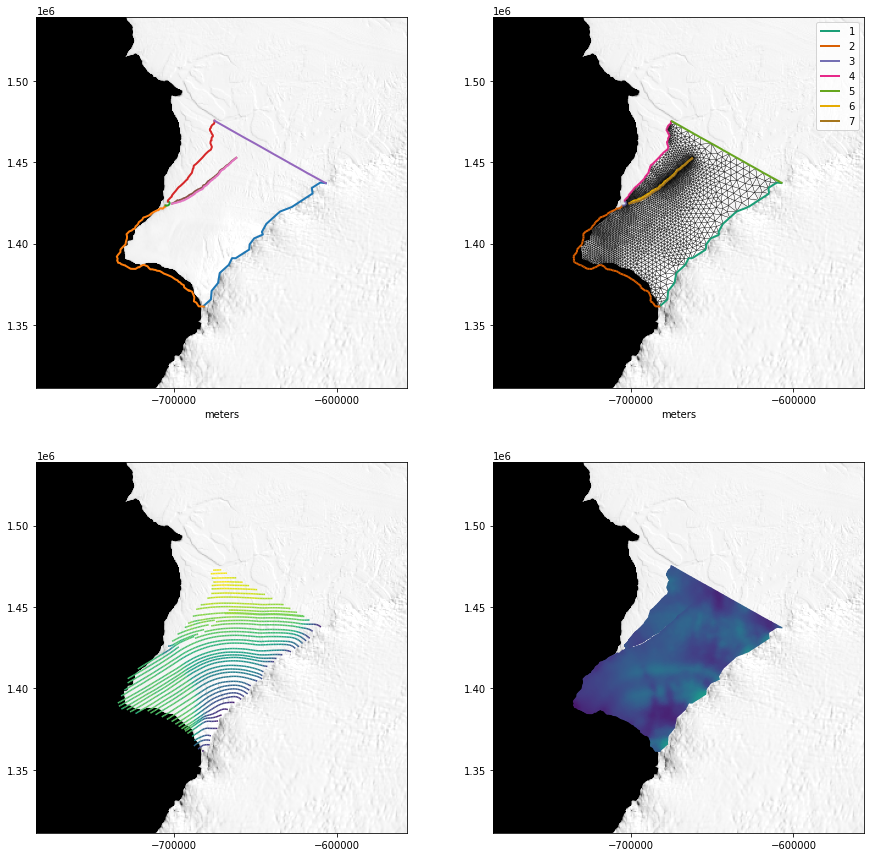

In [10]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

#OUTLINE
axes[0,0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[0,0].plot(xs[:, 0], xs[:, 1], linewidth=2)
axes[0,0].locator_params(axis='x',nbins=4)
axes[0,0].set_xlabel("meters");

#MESH
axes[0,1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[0,1].set_xlabel("meters")
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
icepack.plot.triplot(mesh_2021, axes=axes[0,1], **kwargs)
axes[0,1].locator_params(axis='x',nbins=4)
axes[0,1].legend();

#VELOCITY STREAMLINE
axes[1,0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
streamlines = icepack.plot.streamplot(
    u0_2021, precision=1000, density=2000, axes=axes[1,0]
)
axes[1,0].locator_params(axis='x',nbins=4)
#fig.colorbar(streamlines, label="meters/year");

#THICKNESS RASTER
axes[1,1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(h_2021, vmin=0, vmax=500, axes=axes[1,1])
axes[1,1].locator_params(axis='x',nbins=4)
#fig.colorbar(colors, label="thickness");

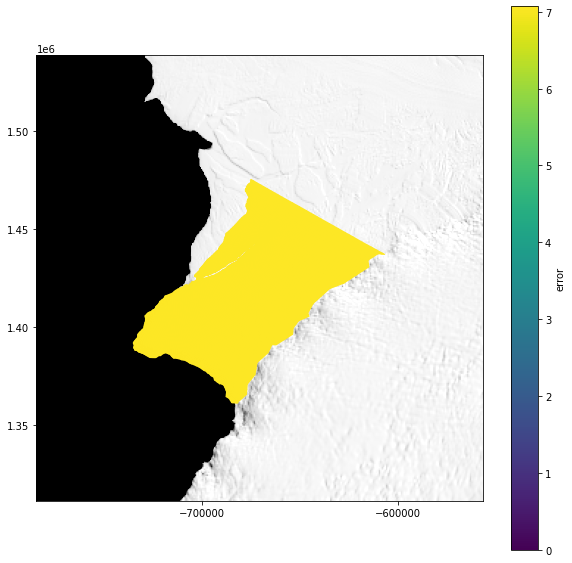

In [11]:
σ_2021 = firedrake.interpolate(firedrake.sqrt(σx_2021**2 + σy_2021**2), Q_2021)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(σ_2021, vmin=0, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors, label="error");

In [12]:
T = Constant(253)
A0 = icepack.rate_factor(T)


def viscosity(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    θ = kwargs["log_fluidity"]

    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )


model = icepack.models.IceShelf(viscosity=viscosity)
opts = {
    "dirichlet_ids": [1, 3, 5],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)

θ = firedrake.Function(Q_2021)
u = solver.diagnostic_solve(
    velocity=u0_2021,
    thickness=h_2021,
    log_fluidity=θ,
)

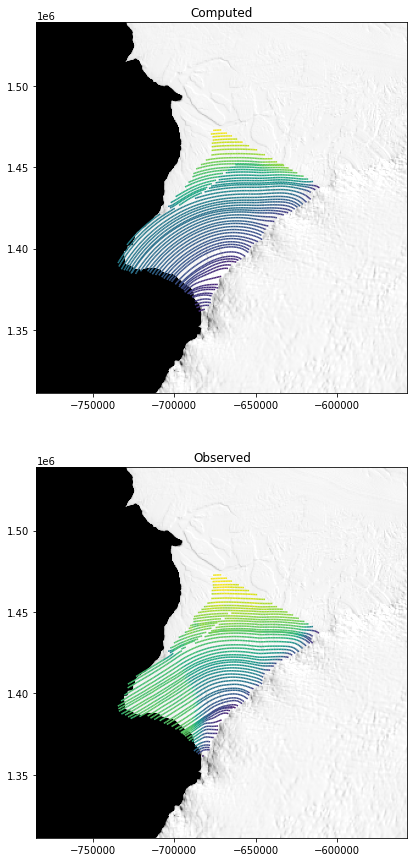

In [13]:
#fig, axes = subplots(ncols=2, sharex=True, sharey=True)
#for ax in axes:
#    ax.get_xaxis().set_visible(False)
#kwargs = {"precision": 1000, "density": 2500, "vmin": 0, "vmax": 750}
#axes[0].set_title("Computed")
#axes[1].set_title("Observed")
#icepack.plot.streamplot(u, axes=axes[0], **kwargs)
#icepack.plot.streamplot(u_obs, axes=axes[1], **kwargs);


fig, axes = plt.subplots(2,1, figsize=(7.5,15))
kwargs = {"precision": 1000, "density": 1500}
axes[0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[0].set_title("Computed")
axes[1].set_title("Observed")
icepack.plot.streamplot(u, axes=axes[0], **kwargs)
icepack.plot.streamplot(u0_2021, axes=axes[1], **kwargs);




### Inferring the fluidity

There are four parts that go into an inverse problem:

* a physics model
* an initial guess for the parameter and state
* an error metric
* a smoothness metric

We already have the physics model and some initial guesses.
The physics are wrapped up in the Python function `simulation` defined below; we'll pass this function when we create the inverse problem.

In [14]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u0_2021,
        thickness=h_2021,
        log_fluidity=θ,
    )

In [15]:
area = Constant(assemble(Constant(1.0) * dx(mesh_2021)))

In [16]:
def loss_functional(u):
    δu = u - u0_2021
    return 0.5 / area * ((δu[0] / σx_2021)**2 + (δu[1] / σy_2021)**2) * dx


def regularization(θ):
    Θ = Constant(1.)
    L = Constant(7.5e3)
    return 0.5 / area * (L / Θ)**2 * inner(grad(θ), grad(θ)) * dx

In [17]:
problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)

In [18]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-2,
    max_iterations=500,
)
θ = estimator.solve()



Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     2.011169e+03   4.344297e-02                  4.344297e-02   
  1     2.011167e+03   4.344309e-02   4.344297e-02   1.086074e-01   3         2         0         1         2         
  2     2.011163e+03   4.344340e-02   1.086074e-01   2.715186e-01   4         3         0         1         2         
  3     2.011151e+03   4.344416e-02   2.715186e-01   6.787964e-01   5         4         0         1         2         
  4     2.011121e+03   4.344605e-02   6.787964e-01   1.696991e+00   6         5         0         1         2         
  5     2.011048e+03   4.345080e-02   1.696991e+00   4.242478e+00   7         6         0         1         2         
  6     2.010863e+03   4.346269e-02   4.242478e+00   1.060619e+01   8         7         0         1         2         
  7     2.010402e+03   4.349245e-02   1.060619e+01   2.651548e+0

  68    1.788399e+02   1.008777e-02   1.471905e+03   1.471905e+03   70        63        0         4         3         
  69    1.750090e+02   6.601939e-03   1.471905e+03   1.471905e+03   71        64        0         4         3         
  70    1.711113e+02   8.461115e-03   1.471905e+03   1.471905e+03   72        65        0         3         3         
  71    1.672020e+02   6.157340e-03   1.471905e+03   3.679763e+03   73        66        0         4         3         
  72    1.602069e+02   1.074972e-02   3.679763e+03   3.679763e+03   74        67        0         4         3         
  73    1.579632e+02   1.175439e-02   3.679763e+03   3.679763e+03   75        68        0         4         2         
  74    1.466326e+02   7.833807e-03   3.679763e+03   3.679763e+03   76        69        0         5         3         
  75    1.410771e+02   1.182372e-02   3.679763e+03   3.679763e+03   77        70        0         5         3         
  76    1.410771e+02   1.182372e-02   3.679763e+

  137   3.818834e+01   2.206785e-03   1.246752e+03   3.116880e+03   139       125       0         4         3         
  138   3.709210e+01   5.369924e-04   3.116880e+03   7.792201e+03   140       126       0         10        3         
  139   3.614102e+01   1.816944e-03   7.792201e+03   7.792201e+03   141       127       0         13        3         
  140   3.429667e+01   1.578087e-03   7.792201e+03   7.792201e+03   142       128       0         17        3         
  141   3.319550e+01   1.424564e-03   7.792202e+03   7.792201e+03   143       129       0         19        3         
  142   3.319550e+01   1.424564e-03   7.792201e+03   4.870125e+02   144       129       2         16        3         
  143   3.282367e+01   1.813059e-03   4.870125e+02   1.217531e+03   145       130       0         3         3         
  144   3.230543e+01   1.080014e-03   1.217531e+03   3.043828e+03   146       131       0         5         3         
  145   3.172067e+01   5.121307e-04   3.043828e+

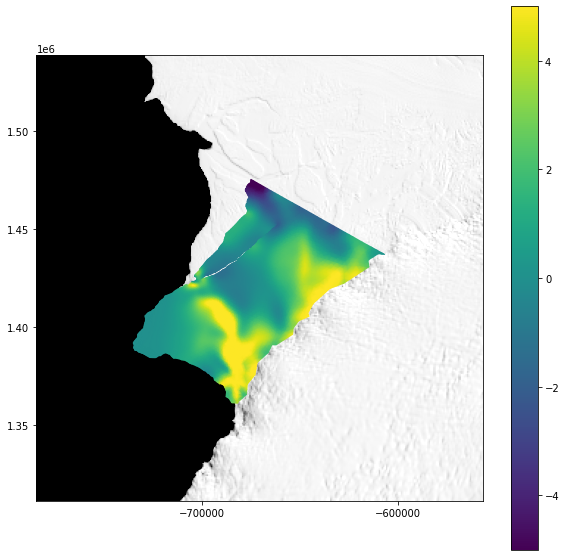

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(θ, vmin=-5, vmax=+5, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

In [20]:
u_2021 = simulation(θ)

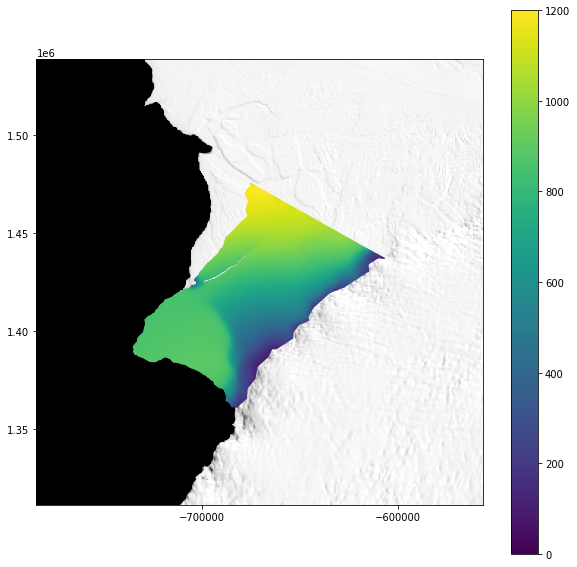

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

### Make tif

In [22]:
shelf_outline = [
( -606837.6, 1437110.4 ), ( -610183.2, 1437503.2 ), ( -615426.3, 1434163.1 ), ( -614941.4, 1430772.5 ), ( -627707.1, 1422470.6 ), ( -634967.3, 1419676.9 ), ( -643370.1, 1412098.9 ), ( -646085.9, 1407167.4 ), ( -645495.2, 1405566.9 ), ( -650852.7, 1403200.7 ), ( -653614.5, 1399491.6 ), ( -653840.4, 1396359.7 ), ( -662256.4, 1391003.6 ), ( -664387.2, 1391078.8 ), ( -666392.8, 1386979.7 ), ( -671966.0, 1381936.3 ), ( -673018.5, 1375798.3 ), ( -676963.7, 1370930.0 ), ( -677400.2, 1365695.3 ), ( -681830.9, 1361740.6 ), ( -681770.4, 1361316.1 ), 
( -681770.4, 1361316.1 ), ( -684916.3, 1361504.0 ), ( -686289.7, 1363718.0 ), ( -687825.9, 1364577.8 ), ( -687556.8, 1367068.9 ), ( -688120.4, 1368564.4 ), ( -688965.7, 1370428.5 ), ( -690656.4, 1371295.5 ), ( -690959.9, 1371013.8 ), ( -693777.7, 1373125.9 ), ( -694019.7, 1374484.2 ), ( -695458.8, 1375210.5 ), ( -696238.9, 1376152.0 ), ( -697208.2, 1376586.4 ), ( -697891.0, 1377458.8 ), ( -699218.6, 1378027.8 ), ( -701532.5, 1379658.9 ), ( -704415.3, 1380910.7 ), ( -706273.9, 1381593.4 ), ( -707563.6, 1382465.9 ), ( -708853.3, 1383186.6 ), ( -710552.5, 1383365.5 ), ( -711369.2, 1383829.0 ), ( -712207.9, 1383917.3 ), ( -713333.5, 1384226.3 ), ( -714547.5, 1384204.2 ), ( -715629.0, 1385197.4 ), ( -716247.0, 1386058.2 ), ( -717725.7, 1386610.0 ), ( -718365.8, 1386985.2 ), ( -719491.5, 1386720.3 ), ( -720595.0, 1386080.3 ), ( -721367.5, 1385418.1 ), ( -721963.5, 1385550.6 ), ( -723657.3, 1384464.6 ), ( -725302.8, 1384486.0 ), ( -726670.5, 1384550.1 ), ( -728252.0, 1385469.0 ), ( -728978.6, 1385917.8 ), ( -729747.9, 1386323.9 ), ( -730047.1, 1386665.8 ), ( -730698.1, 1386730.0 ), ( -731720.9, 1387145.5 ), ( -732360.1, 1387305.4 ), ( -733265.7, 1388093.7 ), ( -734360.2, 1388243.5 ), ( -734616.8, 1389059.7 ), ( -734966.6, 1389526.1 ), ( -734640.1, 1390832.0 ), ( -735176.4, 1391974.7 ), ( -734500.2, 1393024.1 ), ( -732961.0, 1394819.7 ), ( -732891.1, 1396382.1 ), ( -731678.4, 1397734.7 ), ( -729853.9, 1399522.8 ), ( -729505.7, 1401394.2 ), ( -728939.9, 1403178.6 ), ( -728896.4, 1404506.0 ), ( -729201.0, 1405768.1 ), ( -727503.7, 1407508.9 ), ( -726045.8, 1408052.9 ), ( -725110.1, 1408901.6 ), ( -724587.8, 1409010.4 ), ( -724000.3, 1409467.4 ), ( -723652.1, 1410555.4 ), ( -722576.3, 1411485.1 ), ( -722007.7, 1412246.6 ), ( -721652.3, 1413160.4 ), ( -719540.5, 1414744.3 ), ( -718911.0, 1416003.3 ), ( -717348.2, 1416474.4 ), ( -715711.4, 1417194.6 ), ( -714387.5, 1417812.9 ), ( -714409.3, 1418249.4 ), ( -712453.2, 1419464.6 ), ( -710128.5, 1420521.2 ), ( -709608.3, 1420521.2 ), ( -709283.2, 1420862.6 ), ( -709283.2, 1421155.2 ), ( -708145.2, 1421724.2 ), ( -707007.3, 1421415.4 ), ( -705934.3, 1422439.5 ), ( -705381.6, 1422715.9 ), ( -705089.0, 1422911.0 ), ( -705237.7, 1423407.6 ),
( -705237.7, 1423407.6 ), ( -704866.5, 1423373.0 ), ( -704464.1, 1423373.4 ), ( -704260.1, 1423364.9 ), ( -703979.6, 1423398.9 ), ( -703682.0, 1423517.9 ), ( -703446.2, 1423675.2 ), ( -703240.0, 1423823.9 ), ( -703078.5, 1424002.5 ), ( -702877.0, 1424290.1 ), ( -702763.9, 1424606.0 ), ( -702755.4, 1424988.6 ), ( -702823.4, 1425252.1 ), ( -703293.3, 1425747.4 ), ( -703703.6, 1425904.1 ), ( -703786.6, 1425906.7 ),
( -703786.6, 1425906.7 ), ( -703799.3, 1426423.3 ), ( -703534.4, 1426843.6 ), ( -702860.9, 1427488.4 ), ( -702112.5, 1428317.4 ), ( -701467.7, 1428812.5 ), ( -701370.0, 1429155.3 ), ( -701419.6, 1429388.8 ), ( -700952.4, 1430061.2 ), ( -700308.4, 1430853.9 ), ( -699310.4, 1432000.5 ), ( -698921.1, 1432453.5 ), ( -698441.4, 1433079.6 ), ( -697903.6, 1433818.3 ), ( -697197.5, 1434611.3 ), ( -696263.3, 1435328.3 ), ( -694035.6, 1437357.1 ), ( -692830.4, 1438648.8 ), ( -691717.5, 1439588.7 ), ( -691631.0, 1440194.2 ), ( -690290.4, 1441947.7 ), ( -689061.2, 1443460.0 ), ( -688416.7, 1445980.1 ), ( -688089.6, 1446353.9 ), ( -687902.7, 1447825.7 ), ( -686337.5, 1449063.9 ), ( -684445.1, 1450932.8 ), ( -682482.7, 1452942.0 ), ( -680753.9, 1454951.1 ), ( -678985.3, 1456627.5 ), ( -677382.0, 1457736.7 ), ( -676766.9, 1459360.2 ), ( -677694.5, 1461678.0 ), ( -677532.1, 1462951.6 ), ( -676972.8, 1463422.6 ), ( -677078.8, 1463958.3 ), ( -676832.8, 1465264.8 ), ( -676166.9, 1465818.2 ), ( -676223.1, 1466606.1 ), ( -676889.1, 1467562.9 ), ( -677433.2, 1468894.9 ), ( -677855.3, 1469298.2 ), ( -678018.0, 1470026.3 ), ( -677864.9, 1470609.9 ), ( -677463.1, 1471040.5 ), ( -677223.9, 1471872.8 ), ( -676659.5, 1472743.5 ), ( -676037.6, 1473260.1 ), ( -675597.5, 1473422.8 ), ( -675227.1, 1474310.8 ), ( -675195.6, 1475472.8 ),
( -675195.6, 1475472.8 ), ( -672193.0, 1473752.1 ), ( -668783.9, 1471832.9 ), ( -664541.5, 1469408.7 ), ( -661006.2, 1467413.8 ), ( -657285.9, 1465304.9 ), ( -650488.9, 1461569.7 ), ( -643122.6, 1457399.5 ), ( -639355.2, 1455235.3 ), ( -635026.7, 1452830.6 ), ( -630618.1, 1450345.7 ), ( -627091.2, 1448341.8 ), ( -623163.5, 1446177.6 ), ( -618434.2, 1443452.2 ), ( -613705.0, 1440887.2 ), ( -608237.9, 1437866.1 ), ( -606837.6, 1437110.4 ) 
]

shelf_poly = Polygon(shelf_outline)


rift_outline = [
( -701241.6, 1424581.4 ), ( -700522.0, 1424890.9 ), ( -700359.5, 1424898.6 ), ( -699547.1, 1425455.7 ), ( -698773.3, 1425958.6 ), ( -697922.2, 1426631.8 ), ( -697264.6, 1426422.9 ), ( -696912.0, 1426540.3 ), ( -696362.0, 1426882.0 ), ( -696312.0, 1426740.3 ), ( -695495.5, 1427098.6 ), ( -694703.9, 1427515.3 ), ( -693737.3, 1428006.9 ), ( -693595.6, 1427873.6 ), ( -693012.3, 1428173.5 ), ( -691804.1, 1428923.5 ), ( -691020.9, 1429390.1 ), ( -691007.9, 1429534.2 ), ( -690775.5, 1429759.4 ), ( -690034.7, 1430158.8 ), ( -689199.6, 1430485.6 ), ( -688335.4, 1431044.8 ), ( -688110.2, 1431248.1 ), ( -687347.7, 1432010.7 ), ( -685829.3, 1432951.6 ), ( -685298.7, 1433225.0 ), ( -684237.6, 1433707.3 ), ( -684004.4, 1433739.5 ), ( -683401.5, 1434141.4 ), ( -682862.9, 1434326.3 ), ( -682388.5, 1434800.6 ), ( -682227.8, 1435564.4 ), ( -681841.9, 1435869.9 ), ( -681480.1, 1435990.4 ), ( -681118.4, 1435918.1 ), ( -680805.9, 1436065.7 ), ( -680568.1, 1436472.3 ), ( -679862.2, 1437070.7 ), ( -679939.0, 1437285.6 ), ( -679325.2, 1437822.6 ), ( -679355.9, 1438022.1 ), ( -679118.0, 1438306.0 ), ( -678143.7, 1438666.6 ), ( -678020.9, 1438988.8 ), ( -677691.0, 1439295.7 ), ( -677422.5, 1439364.8 ), ( -676747.3, 1439725.3 ), ( -676556.1, 1439888.2 ), ( -676458.9, 1440163.5 ), ( -676191.6, 1440357.9 ), ( -675730.0, 1440576.6 ), ( -675422.3, 1440835.7 ), ( -675033.6, 1440957.2 ), ( -674985.0, 1441256.8 ), ( -674588.1, 1441678.0 ), ( -673608.2, 1442228.7 ), ( -673600.1, 1442414.9 ), ( -672620.2, 1443354.3 ), ( -672425.3, 1443706.7 ), ( -672200.3, 1443915.6 ), ( -672079.8, 1444534.3 ), ( -671067.3, 1445378.0 ), ( -670432.6, 1445795.8 ), ( -669926.3, 1446036.9 ), ( -669653.1, 1446085.1 ), ( -668680.9, 1447089.5 ), ( -667786.0, 1447982.6 ), ( -667435.4, 1448127.4 ), ( -666924.8, 1448226.5 ), ( -666650.4, 1448584.7 ), ( -666299.8, 1449019.1 ), ( -665560.4, 1449567.9 ), ( -664661.1, 1450596.9 ), ( -664213.7, 1450949.0 ), ( -663669.9, 1451259.3 ), ( -663424.7, 1451442.5 ), ( -663022.8, 1451832.6 ), ( -662426.9, 1452277.2 ), ( -662214.8, 1452400.9 ), ( -662038.1, 1452582.0 ), ( -661808.4, 1452705.7 ),
( -661808.4, 1452705.7 ), ( -662197.2, 1452259.5 ), ( -663018.9, 1451610.1 ), ( -663385.5, 1451243.4 ), ( -663681.5, 1451013.7 ), ( -664120.1, 1450764.4 ), ( -664384.1, 1450530.0 ), ( -664539.5, 1450416.5 ), ( -664838.0, 1450014.3 ), ( -665065.3, 1449794.7 ), ( -665216.6, 1449510.5 ), ( -666168.9, 1448776.0 ), ( -666461.1, 1448330.0 ), ( -666601.7, 1448245.0 ), ( -666922.0, 1447865.8 ), ( -667242.4, 1447800.4 ), ( -667477.8, 1447735.0 ), ( -667844.4, 1447446.5 ), ( -668146.1, 1447171.4 ), ( -668234.8, 1446931.9 ), ( -668651.8, 1446647.9 ), ( -668926.9, 1446275.2 ), ( -669210.9, 1446009.0 ), ( -669210.9, 1445893.7 ), ( -669840.9, 1445467.7 ), ( -670249.1, 1445396.8 ), ( -670861.3, 1445015.2 ), ( -671362.3, 1444478.2 ), ( -671549.0, 1444378.2 ), ( -671562.3, 1444144.7 ), ( -671922.5, 1443811.3 ), ( -672122.6, 1443217.7 ), ( -672596.1, 1442630.8 ), ( -672936.2, 1442337.3 ), ( -672962.9, 1442184.0 ), ( -673496.5, 1441610.4 ), ( -674125.6, 1441305.1 ), ( -674505.2, 1440999.2 ), ( -674536.8, 1440767.2 ), ( -674879.6, 1440361.2 ), ( -675153.8, 1440287.4 ), ( -675486.0, 1439986.8 ), ( -676087.1, 1439681.0 ), ( -676276.9, 1439443.7 ), ( -676377.1, 1439143.2 ), ( -676983.3, 1438851.9 ), ( -677155.3, 1438697.5 ), ( -677441.9, 1438618.1 ), ( -677940.3, 1437965.4 ), ( -678341.7, 1437709.6 ), ( -678540.7, 1437572.8 ), ( -678613.6, 1437330.8 ), ( -678998.8, 1437080.9 ), ( -679152.4, 1436604.6 ), ( -679506.8, 1436388.4 ), ( -680440.1, 1435664.5 ), ( -680527.3, 1435472.6 ), ( -680963.5, 1435219.6 ), ( -681425.7, 1435141.1 ), ( -681661.2, 1434992.9 ), ( -682097.3, 1433954.9 ), ( -682566.8, 1433548.3 ), ( -683613.4, 1432969.7 ), ( -684549.3, 1432637.9 ), ( -685008.8, 1432280.5 ), ( -686948.7, 1431106.3 ), ( -687357.1, 1430680.9 ), ( -687306.1, 1430544.8 ), ( -688912.9, 1429446.3 ), ( -689588.0, 1429240.1 ), ( -690113.0, 1428696.3 ), ( -691744.4, 1427758.7 ), ( -694275.8, 1426408.6 ), ( -694800.8, 1426427.4 ), ( -696432.2, 1425639.8 ), ( -696638.4, 1425752.3 ), ( -698963.6, 1424946.0 ), ( -699207.4, 1425002.3 ), ( -700651.2, 1424608.5 ), ( -701241.6, 1424581.4 )
]

rift_poly = Polygon(rift_outline)


In [23]:
tifxmin = -750000
tifxmax = -600000
tifymin = 1350000
tifymax = 1500000
tifres = 100 #250

tifxlen = (tifxmax-tifxmin)/tifres
tifylen = (tifymax-tifymin)/tifres

tifx = np.linspace(tifxmin+(tifres/2),tifxmax-(tifres/2),num=int(tifxlen))
tify = np.linspace(tifymax-(tifres/2),tifymin+(tifres/2),num=int(tifylen))


In [24]:
tras = np.zeros((int(tifxlen),int(tifylen)))
vras = np.zeros((int(tifxlen),int(tifylen)))
vxras = np.zeros((int(tifxlen),int(tifylen)))
vyras = np.zeros((int(tifxlen),int(tifylen)))

for tx in range(0,int(tifxlen)):
    for ty in range(0,int(tifylen)):
        on_shelf = shelf_poly.contains(Point(tifx[tx],tify[ty]))
        in_rift = rift_poly.contains(Point(tifx[tx],tify[ty]))
        
        if (on_shelf==True) & (in_rift==False):
            tras[ty,tx] = θ((tifx[tx],tify[ty]))
            vras[ty,tx] = np.sqrt(u_2021((tifx[tx],tify[ty]))[0] **2 + u_2021((tifx[tx],tify[ty]))[1] **2)
            vxras[ty,tx] = u_2021((tifx[tx],tify[ty]))[0]
            vyras[ty,tx] = u_2021((tifx[tx],tify[ty]))[1]
        else:
            tras[ty,tx] = np.nan
            vras[ty,tx] = np.nan
            vxras[ty,tx] = np.nan
            vyras[ty,tx] = np.nan
            

In [25]:
driver = "GTiff"
dim = vras.shape
height = dim[0]
width = dim[1]
count = 1
dtype = vras.dtype

print(height,width)
print(dtype)


1500 1500
float64


In [26]:
crs = CRS.from_epsg(3031)

transform = from_origin(tifxmin,tifymax,tifres,tifres)

transform

Affine(100.0, 0.0, -750000.0,
       0.0, -100.0, 1500000.0)

In [27]:
with rasterio.open("./fluidity_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(tras,1)

In [28]:
with rasterio.open("./model_velocity_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vras,1)

In [29]:
with rasterio.open("./model_velocity_vx_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vxras,1)

In [30]:
with rasterio.open("./model_velocity_vy_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vyras,1)

### make fig

Ground track angles
western pair: -34.2 deg
western pair: -0.6 rad
eastern pair: -37.3 deg
western pair: -0.65 rad

western pair, seaward
v east: -787.0m/yr, v_north: -259.4 m/yr, v_total: 828.6 m/yr
angle : -108.2 deg
offset: 74.1 deg

western pair, landward
v east: -813.7m/yr, v_north: -340.9 m/yr, v_total: 882.2 m/yr
angle : -112.7 deg
offset: 78.6 deg

eastern pair, seaward
v east: -937.2m/yr, v_north: -80.6 m/yr, v_total: 940.6 m/yr
angle : -94.9 deg
offset: 57.6 deg

eastern pair, landward
v east: -967.6m/yr, v_north: -142.3 m/yr, v_total: 978.0 m/yr
angle : -98.4 deg
offset: 61.1 deg

------------------------------

west,  seaward v_total: 828.6 m/yr
west, landward v_total: 882.2 m/yr
east,  seaward v_total: 940.6 m/yr
east, landward v_total: 978.0 m/yr

west,   seaward v_perp: 227.2 m/yr
west,  landward v_perp: 174.8 m/yr
east,   seaward v_perp: 503.3 m/yr
east,  landward v_perp: 472.6 m/yr

Western opening rate: 52.4 m/yr
Eastern opening rate: 30.7 m/yr


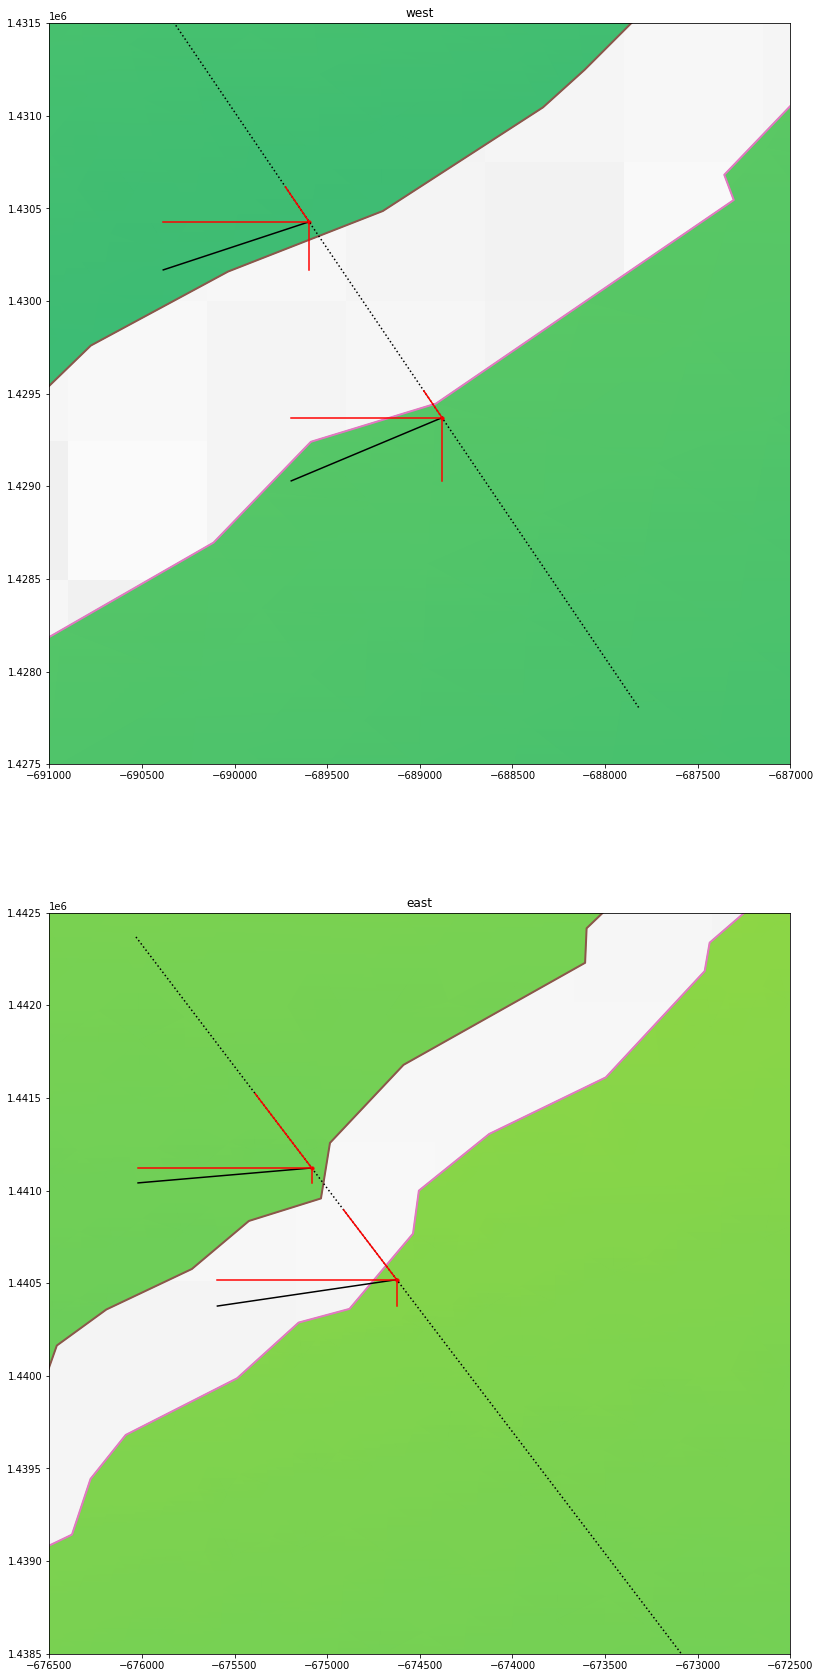

In [31]:
fig, axes = plt.subplots(2,1, figsize=(15,30))

axes[0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=axes[0])

axes[1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=axes[1])

for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[0].plot(xs[:, 0], xs[:, 1], linewidth=2)
        
for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[1].plot(xs[:, 0], xs[:, 1], linewidth=2)
        
axes[0].plot([easting_w_n,easting_w_s],[northing_w_n,northing_w_s],'k:')
axes[1].plot([easting_e_n,easting_e_s],[northing_e_n,northing_e_s],'k:')        
        
axes[0].scatter(w_n_x_calv,w_n_y_calv,s=10,c='r')
axes[0].scatter(w_s_x_calv,w_s_y_calv,s=10,c='r')
axes[1].scatter(e_n_x_calv,e_n_y_calv,s=10,c='r')
axes[1].scatter(e_s_x_calv,e_s_y_calv,s=10,c='r')

#model
vw_n_calv = u_2021((w_n_x_calv,w_n_y_calv))
vw_s_calv = u_2021((w_s_x_calv,w_s_y_calv))
ve_n_calv = u_2021((e_n_x_calv,e_n_y_calv))
ve_s_calv = u_2021((e_s_x_calv,e_s_y_calv))

#ft
ft_vw_n_calv = u0_2021((w_n_x_calv,w_n_y_calv))
ft_vw_s_calv = u0_2021((w_s_x_calv,w_s_y_calv))
ft_ve_n_calv = u0_2021((e_n_x_calv,e_n_y_calv))
ft_ve_s_calv = u0_2021((e_s_x_calv,e_s_y_calv))

#model
vw_n_calv_tot = np.sqrt((vw_n_calv[0]**2)+(vw_n_calv[1]**2))
vw_s_calv_tot = np.sqrt((vw_s_calv[0]**2)+(vw_s_calv[1]**2))
ve_n_calv_tot = np.sqrt((ve_n_calv[0]**2)+(ve_n_calv[1]**2))
ve_s_calv_tot = np.sqrt((ve_s_calv[0]**2)+(ve_s_calv[1]**2))

#ft
ft_vw_n_calv_tot = np.sqrt((ft_vw_n_calv[0]**2)+(ft_vw_n_calv[1]**2))
ft_vw_s_calv_tot = np.sqrt((ft_vw_s_calv[0]**2)+(ft_vw_s_calv[1]**2))
ft_ve_n_calv_tot = np.sqrt((ft_ve_n_calv[0]**2)+(ft_ve_n_calv[1]**2))
ft_ve_s_calv_tot = np.sqrt((ft_ve_s_calv[0]**2)+(ft_ve_s_calv[1]**2))

#axes.arrow(w_n_x_2021,w_n_y_2021,vw_n_2021[0],vw_n_2021[1],head_width=150,color='k')
#axes.arrow(w_s_x_2021,w_s_y_2021,vw_s_2021[0],vw_s_2021[1],head_width=150,color='k')
#axes.arrow(e_n_x_2021,e_n_y_2021,ve_n_2021[0],ve_n_2021[1],head_width=150,color='k')
#axes.arrow(e_s_x_2021,e_s_y_2021,ve_s_2021[0],ve_s_2021[1],head_width=150,color='k')

axes[0].plot([w_n_x_calv,w_n_x_calv+vw_n_calv[0]],[w_n_y_calv,w_n_y_calv+vw_n_calv[1]],color='k')
axes[0].plot([w_s_x_calv,w_s_x_calv+vw_s_calv[0]],[w_s_y_calv,w_s_y_calv+vw_s_calv[1]],color='k')
axes[1].plot([e_n_x_calv,e_n_x_calv+ve_n_calv[0]],[e_n_y_calv,e_n_y_calv+ve_n_calv[1]],color='k')
axes[1].plot([e_s_x_calv,e_s_x_calv+ve_s_calv[0]],[e_s_y_calv,e_s_y_calv+ve_s_calv[1]],color='k')

axes[0].plot([w_n_x_calv,w_n_x_calv+0],[w_n_y_calv,w_n_y_calv+vw_n_calv[1]],color='r')
axes[0].plot([w_s_x_calv,w_s_x_calv+0],[w_s_y_calv,w_s_y_calv+vw_s_calv[1]],color='r')
axes[1].plot([e_n_x_calv,e_n_x_calv+0],[e_n_y_calv,e_n_y_calv+ve_n_calv[1]],color='r')
axes[1].plot([e_s_x_calv,e_s_x_calv+0],[e_s_y_calv,e_s_y_calv+ve_s_calv[1]],color='r')

axes[0].plot([w_n_x_calv,w_n_x_calv+vw_n_calv[0]],[w_n_y_calv,w_n_y_calv+0],color='r')
axes[0].plot([w_s_x_calv,w_s_x_calv+vw_s_calv[0]],[w_s_y_calv,w_s_y_calv+0],color='r')
axes[1].plot([e_n_x_calv,e_n_x_calv+ve_n_calv[0]],[e_n_y_calv,e_n_y_calv+0],color='r')
axes[1].plot([e_s_x_calv,e_s_x_calv+ve_s_calv[0]],[e_s_y_calv,e_s_y_calv+0],color='r')

#model
vw_n_calv_angle = (math.atan(vw_n_calv[1]/vw_n_calv[0]))
vw_s_calv_angle = (math.atan(vw_s_calv[1]/vw_s_calv[0]))
ve_n_calv_angle = (math.atan(ve_n_calv[1]/ve_n_calv[0]))
ve_s_calv_angle = (math.atan(ve_s_calv[1]/ve_s_calv[0]))

#ft
ft_vw_n_calv_angle = (math.atan(ft_vw_n_calv[1]/ft_vw_n_calv[0]))
ft_vw_s_calv_angle = (math.atan(ft_vw_s_calv[1]/ft_vw_s_calv[0]))
ft_ve_n_calv_angle = (math.atan(ft_ve_n_calv[1]/ft_ve_n_calv[0]))
ft_ve_s_calv_angle = (math.atan(ft_ve_s_calv[1]/ft_ve_s_calv[0]))

#model
vw_n_calv_offset = abs(-90-math.degrees(vw_n_calv_angle) - math.degrees(west_angle))
vw_s_calv_offset = abs(-90-math.degrees(vw_s_calv_angle) - math.degrees(west_angle))
ve_n_calv_offset = abs(-90-math.degrees(ve_n_calv_angle) - math.degrees(east_angle))
ve_s_calv_offset = abs(-90-math.degrees(ve_s_calv_angle) - math.degrees(east_angle))

#ft
ft_vw_n_calv_offset = abs(-90-math.degrees(ft_vw_n_calv_angle) - math.degrees(west_angle))
ft_vw_s_calv_offset = abs(-90-math.degrees(ft_vw_s_calv_angle) - math.degrees(west_angle))
ft_ve_n_calv_offset = abs(-90-math.degrees(ft_ve_n_calv_angle) - math.degrees(east_angle))
ft_ve_s_calv_offset = abs(-90-math.degrees(ft_ve_s_calv_angle) - math.degrees(east_angle))

print("Ground track angles")
print("western pair: "+str(round(math.degrees(west_angle),1))+" deg")
print("western pair: "+str(round(west_angle,2))+" rad")
print("eastern pair: "+str(round(math.degrees(east_angle),1))+" deg")
print("western pair: "+str(round(east_angle,2))+" rad")
print("")
print("western pair, seaward")
print("v east: "+str(round(vw_n_calv[0],1))+"m/yr, v_north: "+str(round(vw_n_calv[1],1))+" m/yr, v_total: "+str(round(vw_n_calv_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(vw_n_calv_angle),1))+" deg")
print("offset: "+str(round(vw_n_calv_offset,1))+" deg")
print("")
print("western pair, landward")
print("v east: "+str(round(vw_s_calv[0],1))+"m/yr, v_north: "+str(round(vw_s_calv[1],1))+" m/yr, v_total: "+str(round(vw_s_calv_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(vw_s_calv_angle),1))+" deg")
print("offset: "+str(round(vw_s_calv_offset,1))+" deg")
print("")
print("eastern pair, seaward")
print("v east: "+str(round(ve_n_calv[0],1))+"m/yr, v_north: "+str(round(ve_n_calv[1],1))+" m/yr, v_total: "+str(round(ve_n_calv_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(ve_n_calv_angle),1))+" deg")
print("offset: "+str(round(ve_n_calv_offset,1))+" deg")
print("")
print("eastern pair, landward")
print("v east: "+str(round(ve_s_calv[0],1))+"m/yr, v_north: "+str(round(ve_s_calv[1],1))+" m/yr, v_total: "+str(round(ve_s_calv_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(ve_s_calv_angle),1))+" deg")
print("offset: "+str(round(ve_s_calv_offset,1))+" deg")
print("")
print("------------------------------")
print("")
#calculate component of velocity in rift perpendicular direction
print("west,  seaward v_total: "+str(round(vw_n_calv_tot,1))+" m/yr")
print("west, landward v_total: "+str(round(vw_s_calv_tot,1))+" m/yr")
print("east,  seaward v_total: "+str(round(ve_n_calv_tot,1))+" m/yr")
print("east, landward v_total: "+str(round(ve_s_calv_tot,1))+" m/yr")
print("")

#model
vw_n_calv_perp = vw_n_calv_tot * math.cos(math.radians(vw_n_calv_offset))
vw_s_calv_perp = vw_s_calv_tot * math.cos(math.radians(vw_s_calv_offset))
ve_n_calv_perp = ve_n_calv_tot * math.cos(math.radians(ve_n_calv_offset))
ve_s_calv_perp = ve_s_calv_tot * math.cos(math.radians(ve_s_calv_offset))

#ft
ft_vw_n_calv_perp = ft_vw_n_calv_tot * math.cos(math.radians(ft_vw_n_calv_offset))
ft_vw_s_calv_perp = ft_vw_s_calv_tot * math.cos(math.radians(ft_vw_s_calv_offset))
ft_ve_n_calv_perp = ft_ve_n_calv_tot * math.cos(math.radians(ft_ve_n_calv_offset))
ft_ve_s_calv_perp = ft_ve_s_calv_tot * math.cos(math.radians(ft_ve_s_calv_offset))

print("west,   seaward v_perp: "+str(round(vw_n_calv_perp,1))+" m/yr")
print("west,  landward v_perp: "+str(round(vw_s_calv_perp,1))+" m/yr")
print("east,   seaward v_perp: "+str(round(ve_n_calv_perp,1))+" m/yr")
print("east,  landward v_perp: "+str(round(ve_s_calv_perp,1))+" m/yr")
print("")

axes[0].plot([w_n_x_calv,w_n_x_calv+(vw_n_calv_perp*math.sin(west_angle))],[w_n_y_calv,w_n_y_calv+(vw_n_calv_perp*math.cos(west_angle))],color='r')
axes[0].plot([w_s_x_calv,w_s_x_calv+(vw_s_calv_perp*math.sin(west_angle))],[w_s_y_calv,w_s_y_calv+(vw_s_calv_perp*math.cos(west_angle))],color='r')
axes[1].plot([e_n_x_calv,e_n_x_calv+(ve_n_calv_perp*math.sin(east_angle))],[e_n_y_calv,e_n_y_calv+(ve_n_calv_perp*math.cos(east_angle))],color='r')
axes[1].plot([e_s_x_calv,e_s_x_calv+(ve_s_calv_perp*math.sin(east_angle))],[e_s_y_calv,e_s_y_calv+(ve_s_calv_perp*math.cos(east_angle))],color='r')

#difference across rift
#model
vdiffw_calv = vw_n_calv_perp - vw_s_calv_perp
vdiffe_calv = ve_n_calv_perp - ve_s_calv_perp

#ft
ft_vdiffw_calv = ft_vw_n_calv_perp - ft_vw_s_calv_perp
ft_vdiffe_calv = ft_ve_n_calv_perp - ft_ve_s_calv_perp

print("Western opening rate: "+str(round(vdiffw_calv,1))+" m/yr")
print("Eastern opening rate: "+str(round(vdiffe_calv,1))+" m/yr")

axes[0].set_title("west")
axes[0].set_xlim(xcen_w-delta,xcen_w+delta)
axes[0].set_ylim(ycen_w-delta,ycen_w+delta)

axes[1].set_title("east")
axes[1].set_xlim(xcen_e-delta,xcen_e+delta)
axes[1].set_ylim(ycen_e-delta,ycen_e+delta)

plt.show()

In [32]:
print("------------------------------")
print("Geometry: calving")
print("Rift:     calving")
print("Model:    Near-calving rift opening rate")
print("Temp:     Inverse")
print("")
print("Opening rates: feature tracking")
print("Western:  "+str(round(ft_vdiffw_calv,1))+" m/yr")
print("Eastern:  "+str(round(ft_vdiffe_calv,1))+" m/yr")
print("")
print("Opening rates: model")
print("Western:  "+str(round(vdiffw_calv,1))+" m/yr")
print("Eastern:  "+str(round(vdiffe_calv,1))+" m/yr")

------------------------------
Geometry: calving
Rift:     calving
Model:    Near-calving rift opening rate
Temp:     Inverse

Opening rates: feature tracking
Western:  -2.2 m/yr
Eastern:  4.7 m/yr

Opening rates: model
Western:  52.4 m/yr
Eastern:  30.7 m/yr


### Figure

In [33]:
#calving Sentinel-2

sentinel_out_B2_ps = '/home/sermilik/brunt_model/imagery/calving/20210314T100059_B2_ps_merge_crop.tif'
sentinel_out_B3_ps = '/home/sermilik/brunt_model/imagery/calving/20210314T100059_B3_ps_merge_crop.tif'
sentinel_out_B4_ps = '/home/sermilik/brunt_model/imagery/calving/20210314T100059_B4_ps_merge_crop.tif'
              
img1_2 = rasterio.open(sentinel_out_B2_ps)
img1_3 = rasterio.open(sentinel_out_B3_ps)
img1_4 = rasterio.open(sentinel_out_B4_ps)

#crop to 99th percentile (stops dull images)
image1_2 = img1_2.read(1)
image1_2[image1_2 > np.percentile(image1_2,99)] = np.percentile(image1_2,99)
image1_3 = img1_3.read(1)
image1_3[image1_3 > np.percentile(image1_3,99)] = np.percentile(image1_3,99)
image1_4 = img1_4.read(1)
image1_4[image1_4 > np.percentile(image1_4,99)] = np.percentile(image1_4,99)

image1 = np.array([image1_2, image1_3, image1_4]).transpose(1,2,0)
s2_calve_norm1 = (image1 * (255 / np.max(image1))).astype(np.uint8)


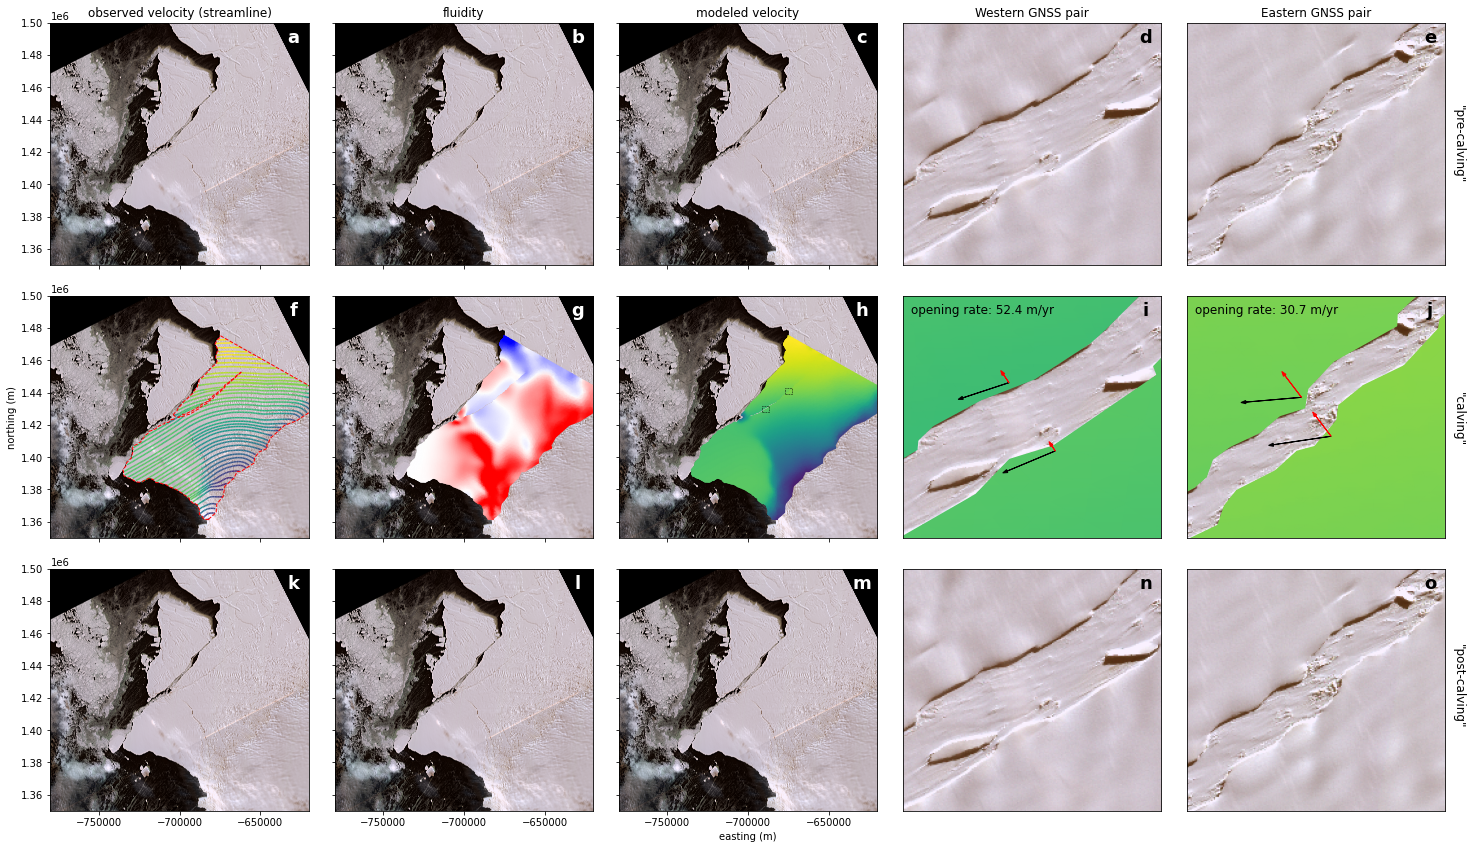

In [34]:
xmin = -780000
xmax = -620000 #160000 wide
ymin = 1350000 
ymax = 1500000 #150000 tall

gr = 0.25

fig,ax=plt.subplots(3,5,figsize=(25,15),gridspec_kw={'wspace': 0.1,'hspace': 0.0125})

#------------------------------------------------------------------------------------
#observed velocity
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[1][0])

kwargs = {"precision": 1000, "density": 2000}
stream=icepack.plot.streamplot(u0_2021, vmin=0, vmax=1200, axes=ax[1][0], **kwargs)

for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        ax[1][0].plot(xs[:, 0], xs[:, 1], linewidth=1, color='r', linestyle='--')

#ax[1][0].add_patch(Rectangle((-775000,1355000),35000,110000,
#                    edgecolor = 'none',
#                    facecolor = 'white',
#                    alpha = 0.5))

#cbaxes0 = inset_axes(ax[1][0], width="3%", height="40%",loc='lower left',borderpad=2)
#cbar0 = plt.colorbar(stream,cax=cbaxes0, ticks=[0,200,400,600,800,1000,1200])        

#ax[1][0].annotate("m/yr",(-765000,1440000),size=12,ha='left',va='top')

#ax[1][0].plot([-765000,-750000],[1447500,1447500],linewidth=1, color='r', linestyle='--')
     
#ax[1][0].annotate("domain",(-771000,1459000),size=12,ha='left',va='top')
       
#------------------------------------------------------------------------------------
#fluidity        
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[1][1])

colors_flow = icepack.plot.tripcolor(θ, vmin=-5, vmax=+5, cmap='bwr', axes=ax[1][1])

#ax[1][1].add_patch(Rectangle((-775000,1355000),35000,90000,
#                    edgecolor = 'none',
#                    facecolor = 'white',
#                    alpha = 0.5))

#cbaxes1 = inset_axes(ax[1][1], width="3%", height="40%",loc='lower left',borderpad=2)
#cbar1 = plt.colorbar(colors_flow,cax=cbaxes1, ticks=[-5,-2.5,0,2.5,5])        

#ax[1][1].annotate("m/yr",(-765000,1440000),size=12,ha='left',va='top')        
        
#------------------------------------------------------------------------------------
#modeled velocity
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[1][2])

colors_vel1 = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax[1][2])

#ax[1][2].add_patch(Rectangle((-775000,1355000),35000,90000,
#                    edgecolor = 'none',
#                    facecolor = 'white',
#                    alpha = 0.5))

#cbaxes2 = inset_axes(ax[1][2], width="3%", height="40%",loc='lower left',borderpad=2)
#cbar2 = plt.colorbar(stream,cax=cbaxes2, ticks=[0,200,400,600,800,1000,1200])        

#ax[1][2].annotate("m/yr",(-765000,1440000),size=12,ha='left',va='top')

#------------------------------------------------------------------------------------
#western
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[1][3])

colors_vel2 = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax[1][3])

#extraction locations        
#ax[1][3].scatter(w_n_x_calv,w_n_y_calv,s=10,c='r')
#ax[1][3].scatter(w_s_x_calv,w_s_y_calv,s=10,c='r')

ax[1][3].arrow(w_n_x_calv,w_n_y_calv,vw_n_calv[0],vw_n_calv[1],head_width=50,color='k',length_includes_head=True)
ax[1][3].arrow(w_s_x_calv,w_s_y_calv,vw_s_calv[0],vw_s_calv[1],head_width=50,color='k',length_includes_head=True)
ax[1][3].arrow(w_n_x_calv,w_n_y_calv,vw_n_calv_perp*math.sin(west_angle),vw_n_calv_perp*math.cos(west_angle),head_width=50,color='r',length_includes_head=True)
ax[1][3].arrow(w_s_x_calv,w_s_y_calv,vw_s_calv_perp*math.sin(west_angle),vw_s_calv_perp*math.cos(west_angle),head_width=50,color='r',length_includes_head=True)

w_ns_x_average = (w_n_x_calv + w_s_x_calv) / 2
w_ns_y_average = (w_n_y_calv + w_s_y_calv) / 2

xmin_w = w_ns_x_average - 2000
xmax_w = w_ns_x_average + 2000
ymin_w = w_ns_y_average - 1875
ymax_w = w_ns_y_average + 1875

ax[1][3].annotate("opening rate: "+str(round(vdiffw_calv,1))+" m/yr",(xmin_w+5000/40,ymax_w-5000/40),size=12,ha='left',va='top')

ax[1][2].plot([xmin_w,xmin_w,xmax_w,xmax_w,xmin_w],\
           [ymin_w,ymax_w,ymax_w,ymin_w,ymin_w],\
           '--',color='k',linewidth=0.5)




#------------------------------------------------------------------------------------
#eastern
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[1][4])

colors_vel3 = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax[1][4])

#extraction locations
#ax[1][4].scatter(e_n_x_calv,e_n_y_calv,s=10,c='r')
#ax[1][4].scatter(e_s_x_calv,e_s_y_calv,s=10,c='r')

ax[1][4].arrow(e_n_x_calv,e_n_y_calv,ve_n_calv[0],ve_n_calv[1],head_width=50,color='k',length_includes_head=True)
ax[1][4].arrow(e_s_x_calv,e_s_y_calv,ve_s_calv[0],ve_s_calv[1],head_width=50,color='k',length_includes_head=True)
ax[1][4].arrow(e_n_x_calv,e_n_y_calv,ve_n_calv_perp*math.sin(east_angle),ve_n_calv_perp*math.cos(east_angle),head_width=50,color='r',length_includes_head=True)
ax[1][4].arrow(e_s_x_calv,e_s_y_calv,ve_s_calv_perp*math.sin(east_angle),ve_s_calv_perp*math.cos(east_angle),head_width=50,color='r',length_includes_head=True)

e_ns_x_average = (e_n_x_calv + e_s_x_calv) / 2
e_ns_y_average = (e_n_y_calv + e_s_y_calv) / 2

xmin_e = e_ns_x_average - 2000
xmax_e = e_ns_x_average + 2000
ymin_e = e_ns_y_average - 1875
ymax_e = e_ns_y_average + 1875

ax[1][4].annotate("opening rate: "+str(round(vdiffe_calv,1))+" m/yr",(xmin_e+5000/40,ymax_e-5000/40),size=12,ha='left',va='top')

ax[1][2].plot([xmin_e,xmin_e,xmax_e,xmax_e,xmin_e],\
           [ymin_e,ymax_e,ymax_e,ymin_e,ymin_e],\
           '--',color='k',linewidth=0.5)





#------------------------------------------------------------------------------------
#other

show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[0][0])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[0][1])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[0][2])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[0][3])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[0][4])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[2][0])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[2][1])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[2][2])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[2][3])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax[2][4])




ax[0][0].set_title('observed velocity (streamline)')
ax[0][1].set_title('fluidity')
ax[0][2].set_title('modeled velocity')
ax[0][3].set_title('Western GNSS pair')
ax[0][4].set_title('Eastern GNSS pair')

ax[0][0].set_xticklabels([])
ax[0][1].set_xticklabels([])
ax[0][2].set_xticklabels([])
ax[0][1].set_yticklabels([])
ax[0][2].set_yticklabels([])
ax[1][0].set_xticklabels([])
ax[1][1].set_xticklabels([])
ax[1][2].set_xticklabels([])
ax[1][1].set_yticklabels([])
ax[1][2].set_yticklabels([])
ax[2][1].set_yticklabels([])
ax[2][2].set_yticklabels([])
ax[0][0].locator_params(axis='x', nbins=5)
ax[0][1].locator_params(axis='x', nbins=5)
ax[0][2].locator_params(axis='x', nbins=5)
ax[1][0].locator_params(axis='x', nbins=5)
ax[1][1].locator_params(axis='x', nbins=5)
ax[1][2].locator_params(axis='x', nbins=5)
ax[2][0].locator_params(axis='x', nbins=5)
ax[2][1].locator_params(axis='x', nbins=5)
ax[2][2].locator_params(axis='x', nbins=5)

ax[0][3].set_xticks([])
ax[0][3].set_yticks([])
ax[0][4].set_xticks([])
ax[0][4].set_yticks([])
ax[1][3].set_xticks([])
ax[1][3].set_yticks([])
ax[1][4].set_xticks([])
ax[1][4].set_yticks([])
ax[2][3].set_xticks([])
ax[2][3].set_yticks([])
ax[2][4].set_xticks([])
ax[2][4].set_yticks([])
ax[0][3].set_xticklabels([])
ax[0][3].set_yticklabels([])
ax[0][4].set_xticklabels([])
ax[0][4].set_yticklabels([])
ax[1][3].set_xticklabels([])
ax[1][3].set_yticklabels([])
ax[1][4].set_xticklabels([])
ax[1][4].set_yticklabels([])
ax[2][3].set_xticklabels([])
ax[2][3].set_yticklabels([])
ax[2][4].set_xticklabels([])
ax[2][4].set_yticklabels([])

ax[0][0].set_xlim(xmin,xmax)
ax[0][0].set_ylim(ymin,ymax) 
ax[0][1].set_xlim(xmin,xmax)
ax[0][1].set_ylim(ymin,ymax) 
ax[0][2].set_xlim(xmin,xmax)
ax[0][2].set_ylim(ymin,ymax)

ax[1][0].set_xlim(xmin,xmax)
ax[1][0].set_ylim(ymin,ymax) 
ax[1][1].set_xlim(xmin,xmax)
ax[1][1].set_ylim(ymin,ymax) 
ax[1][2].set_xlim(xmin,xmax)
ax[1][2].set_ylim(ymin,ymax)

ax[2][0].set_xlim(xmin,xmax)
ax[2][0].set_ylim(ymin,ymax) 
ax[2][1].set_xlim(xmin,xmax)
ax[2][1].set_ylim(ymin,ymax) 
ax[2][2].set_xlim(xmin,xmax)
ax[2][2].set_ylim(ymin,ymax)

#temp
ax[0][3].set_xlim(xmin_w,xmax_w)
ax[0][3].set_ylim(ymin_w,ymax_w)
ax[0][4].set_xlim(xmin_e,xmax_e)
ax[0][4].set_ylim(ymin_e,ymax_e)
ax[1][3].set_xlim(xmin_w,xmax_w)
ax[1][3].set_ylim(ymin_w,ymax_w)
ax[1][4].set_xlim(xmin_e,xmax_e)
ax[1][4].set_ylim(ymin_e,ymax_e)
ax[2][3].set_xlim(xmin_w,xmax_w)
ax[2][3].set_ylim(ymin_w,ymax_w)
ax[2][4].set_xlim(xmin_e,xmax_e)
ax[2][4].set_ylim(ymin_e,ymax_e)


#ax[0][4].scatter(-620000,1425000,s=10,c='r') #use for positioning
#ax[0][4].text(-618000, 1404000, '"pre-calving"', rotation=-90, fontsize=12) #a
#ax[1][4].scatter(-620000,1425000,s=10,c='r')
#ax[1][4].text(-618000, 1410000, '"calving"', rotation=-90, fontsize=12) #v
#ax[2][4].scatter(-620000,1425000,s=10,c='r')
#ax[2][4].text(-618000, 1402000, '"post-calving"', rotation=-90, fontsize=12) # ca
#ax[1][4].scatter(xmax_e,e_ns_y_average,s=10,c='r') #use for positioning
ax[0][4].text(xmax_e+100, e_ns_y_average-550, '"pre-calving"', rotation=-90, fontsize=12) #a
ax[1][4].text(xmax_e+100, e_ns_y_average-400, '"calving"', rotation=-90, fontsize=12) #v
ax[2][4].text(xmax_e+100, e_ns_y_average-550, '"post-calving"', rotation=-90, fontsize=12) # ca



ax[0][0].annotate("a",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[0][1].annotate("b",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[0][2].annotate("c",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[0][3].annotate("d",(xmax_w-((0.06)*(xmax_w-xmin_w)),ymax_w-(0.06*(ymax_w-ymin_w))),\
             size=18,weight='bold',ha='center',va='center')
ax[0][4].annotate("e",(xmax_e-((0.06)*(xmax_e-xmin_e)),ymax_e-(0.06*(ymax_e-ymin_e))),\
             size=18,weight='bold',ha='center',va='center')

ax[1][0].annotate("f",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[1][1].annotate("g",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[1][2].annotate("h",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[1][3].annotate("i",(xmax_w-((0.06)*(xmax_w-xmin_w)),ymax_w-(0.06*(ymax_w-ymin_w))),\
             size=18,weight='bold',ha='center',va='center')
ax[1][4].annotate("j",(xmax_e-((0.06)*(xmax_e-xmin_e)),ymax_e-(0.06*(ymax_e-ymin_e))),\
             size=18,weight='bold',ha='center',va='center')

ax[2][0].annotate("k",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[2][1].annotate("l",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[2][2].annotate("m",(xmax-((0.06)*(xmax-xmin)),ymax-(0.06*(ymax-ymin))),\
             size=18,weight='bold',ha='center',va='center',color='w')
ax[2][3].annotate("n",(xmax_w-((0.06)*(xmax_w-xmin_w)),ymax_w-(0.06*(ymax_w-ymin_w))),\
             size=18,weight='bold',ha='center',va='center')
ax[2][4].annotate("o",(xmax_e-((0.06)*(xmax_e-xmin_e)),ymax_e-(0.06*(ymax_e-ymin_e))),\
             size=18,weight='bold',ha='center',va='center')

ax[1][0].set_ylabel("northing (m)") 
ax[2][2].set_xlabel("easting (m)")

#plt.tight_layout()

output = 'fig07_model_p2.png'
plt.savefig(output, dpi=300, bbox_inches='tight')

plt.show()